In [19]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using MeshCat
const mc = MeshCat
using StaticArrays
using Printf
using Plots

include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","walker.jl"))

  Activating project at `~/OCRL_Project/HW4_Project_Updated`


update_walker_pose! (generic function with 1 method)

# Passive Walker Dynamics

Position and velocity of each body:

$$ \begin{align} 
r^{(b)} &= \begin{bmatrix} p_x^{(b)} \\ p_y^{(b)} \end{bmatrix} & v^{(b)} &= \begin{bmatrix} v_x^{(b)} \\ v_y^{(b)} \end{bmatrix}\\
r^{(1)} &= \begin{bmatrix} p_x^{(1)} \\ p_y^{(1)} \end{bmatrix} & v^{(1)} &= \begin{bmatrix} v_x^{(1)}\\
v_y^{(1)} \end{bmatrix}\\
r^{(2)} &= \begin{bmatrix} p_x^{(2)} \\ p_y^{(2)} \end{bmatrix} & v^{(2)} &= \begin{bmatrix} v_x^{(2)}\\
v_y^{(2)} \end{bmatrix}
\end{align}$$

State and control vectors:


$$ x = \begin{bmatrix} 
    p_x^{(b)} \\ p_y^{(b)} \\ p_x^{(1)} \\ p_y^{(1)} \\ p_x^{(2)} \\ p_y^{(2)} \\
    v_x^{(b)} \\ v_y^{(b)} \\ v_x^{(1)} \\ v_y^{(1)} \\ v_x^{(2)} \\ v_y^{(2)} \\
\end{bmatrix} \quad
u = \begin{bmatrix} F^{(1)} \\ F^{(2)} \\ \tau \end{bmatrix}
$$
where e.g. $p_x^{(b)}$ is the $x$ position of the body, $v_y^{(i)}$ is the $y$ velocity of foot $i$, $F^{(i)}$ is the force along leg $i$, and $\tau$ is the torque between the legs.

In [20]:
function stance1_dynamics(model::NamedTuple, x::Vector, u::Vector)
    # dynamics when foot 1 is in contact with the ground 
    
    mb,mf = model.mb, model.mf
    g = model.g

    M = Diagonal([mb mb mf mf mf mf])
    
    rb  = x[1:2]   # position of the body
    rf1 = x[3:4]   # position of foot 1
    rf2 = x[5:6]   # position of foot 2
    v   = x[7:12]  # velocities
    
    
    ℓ1x = (rb[1]-rf1[1])/norm(rb-rf1)
    ℓ1y = (rb[2]-rf1[2])/norm(rb-rf1)
    ℓ2x = (rb[1]-rf2[1])/norm(rb-rf2)
    ℓ2y = (rb[2]-rf2[2])/norm(rb-rf2)
    
    B = [ℓ1x  ℓ2x  ℓ1y-ℓ2y;
         ℓ1y  ℓ2y  ℓ2x-ℓ1x;
          0    0     0;
          0    0     0;
          0  -ℓ2x  ℓ2y;
          0  -ℓ2y -ℓ2x]
    
    v̇ = [0; -g; 0; 0; 0; -g] + M\(B*u)
    
    ẋ = [v; v̇]
    
    return ẋ
end

function stance2_dynamics(model::NamedTuple, x::Vector, u::Vector)
    # dynamics when foot 2 is in contact with the ground 
    
    mb,mf = model.mb, model.mf
    g = model.g
    M = Diagonal([mb mb mf mf mf mf])
    
    rb  = x[1:2]   # position of the body
    rf1 = x[3:4]   # position of foot 1
    rf2 = x[5:6]   # position of foot 2
    v   = x[7:12]  # velocities
    
    ℓ1x = (rb[1]-rf1[1])/norm(rb-rf1)
    ℓ1y = (rb[2]-rf1[2])/norm(rb-rf1)
    ℓ2x = (rb[1]-rf2[1])/norm(rb-rf2)
    ℓ2y = (rb[2]-rf2[2])/norm(rb-rf2)
    
    B = [ℓ1x  ℓ2x  ℓ1y-ℓ2y;
         ℓ1y  ℓ2y  ℓ2x-ℓ1x;
        -ℓ1x   0  -ℓ1y;
        -ℓ1y   0   ℓ1x;
          0    0    0;
          0    0    0]
    
    v̇ = [0; -g; 0; -g; 0; 0] + M\(B*u)
    
    ẋ = [v; v̇]
    
    return ẋ
end

function jump1_map(x)
    # foot 1 experiences inelastic collision
    xn = [x[1:8]; 0.0; 0.0; x[11:12]]
    return xn
end

function jump2_map(x)
    # foot 2 experiences inelastic collision
    xn = [x[1:10]; 0.0; 0.0]
    return xn
end

function rk4(model::NamedTuple, ode::Function, x::Vector, u::Vector, dt::Real)::Vector
    k1 = dt * ode(model, x,        u)
    k2 = dt * ode(model, x + k1/2, u)
    k3 = dt * ode(model, x + k2/2, u)
    k4 = dt * ode(model, x + k3,   u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end  


rk4 (generic function with 1 method)

Mode switch at step 5 (stance1->stance2), applying jump2_map
Mode switch at step 10 (stance2->stance1), applying jump1_map
Mode switch at step 15 (stance1->stance2), applying jump2_map
Mode switch at step 20 (stance2->stance1), applying jump1_map
Mode switch at step 25 (stance1->stance2), applying jump2_map
Mode switch at step 30 (stance2->stance1), applying jump1_map
Mode switch at step 35 (stance1->stance2), applying jump2_map
Mode switch at step 40 (stance2->stance1), applying jump1_map


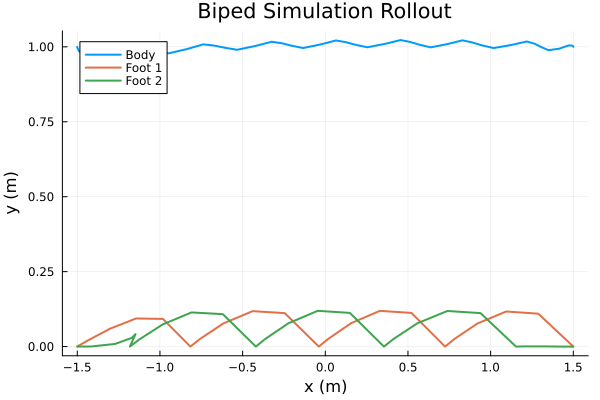

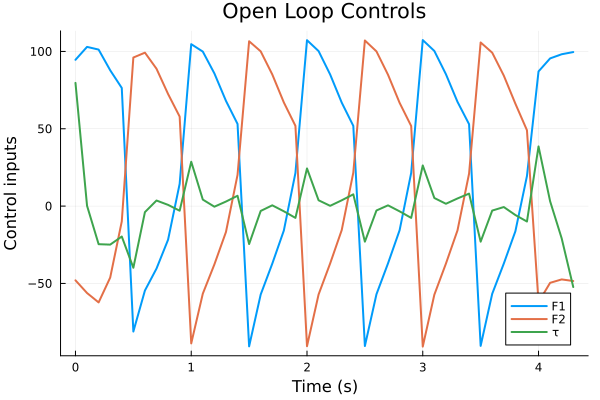

In [21]:
# 10 hz
# but can run at 1/10 real time speed
# resolve trajopt problem often, close the loop in a sim
#make a simulator for the dynamics where you implement the dynamics in a normal hybrid dynamics rollout loop

#solve ipopt problem
#take initial conditioins and roll it out in simulator. and if there's no noise it should just simulate
#1. take dynamics from hw, code up as a simulator. refer to hybrid systems lecture. literally just roll out the dynamics
#compare the u's from the original problem and the simulator - should be same

#step 2. Add disturbance, it should totally not work
# take mpc problem

#add noise to controls not rk4
#xk+1 from simulation becomes xic in controller
# then loop back = this is closing the loop 


model = (g = 9.81, mb = 5.0, mf = 1.0, ℓ_min = 0.5, ℓ_max = 1.5)
nx = 12
nu = 3
tf = 4.4
dt = 0.1 # = 10 hz
t_vec = 0:dt:tf
N = length(t_vec)

# initial and goal states
xic = [-1.5;1;-1.5;0;-1.5;0;0;0;0;0;0;0]
xg =  [1.5;1;1.5;0;1.5;0;0;0;0;0;0;0]

M1 = vcat([ (i-1)*10      .+ (1:5)   for i = 1:5]...) 
M2 = vcat([((i-1)*10 + 5) .+ (1:5)   for i = 1:4]...) 
J1 = [5,15,25,35]
J2 = [10,20,30,40]

# Simulation Loop - Roll out the dynamics using rk4
Tfinal = tf  # final time
Nt = N  # number of time steps

thist = Array(range(0, dt*(Nt-1), step=dt));
xhist = zeros(nx, Nt)
xhist[:,1] = xic
# U's from HW 4 Q2 solution to compare with
uhist = [[94.58907085002882, -48.004977270493136, 79.6671314959405], 
    [102.94618000348852, -56.2229297395955, 0.20512333654955492], 
    [101.19847937056879, -62.29156643517716, -24.640217913502127], 
    [87.82372476960514, -46.22687729568461, -24.915187721183088], 
    [76.38225211230424, -9.933266120703909, -19.677623778780955], 
    [-81.12640305414163, 96.06454417533679, -39.88179872564329], 
    [-54.60075316292386, 99.21985317538804, -3.906377178109968], 
    [-40.40576446245211, 88.80533489644289, 3.602306359751091], 
    [-21.743000618392855, 72.46963201772463, 0.780486489435583], 
    [14.393231648839194, 57.86896094535159, -2.9922591342376763], 
    [104.70897242503732, -88.79200190608096, 28.66787186170999], 
    [99.9031385252462, -56.63335774818436, 4.198637208644066], 
    [85.7880663298205, -37.70824858242344, -0.3949770606904491], 
    [68.03235523910794, -16.74551433888308, 2.928146491725802], 
    [53.115437965785794, 20.176859108621144, 6.66890352803976], 
    [-90.7107272886958, 106.58553505965415, -24.542250167257578], 
    [-57.175357895015374, 100.05927824781388, -3.14422224956232], 
    [-37.248321763635865, 85.13843948704799, 0.4920828787554873], 
    [-15.79956177091657, 67.00626310541163, -3.362828291162563], 
    [21.41730357814945, 51.88661175071195, -7.6365429267876115], 
    [107.2723211114239, -90.60277178697335, 24.342543777774175], 
    [100.23442895130508, -57.17562572531257, 3.76190691411448], 
    [85.09905369886418, -37.09715046346631, 0.16633244277422904], 
    [66.91153561065579, -15.522349785682344, 3.7385762211974516], 
    [51.865806728348694, 21.60734905967089, 7.596154863060844], 
    [-90.50099797945997, 107.0972937343389, -23.000053803218705], 
    [-57.012287668125474, 100.03226614133752, -2.8463748487893445], 
    [-37.0086281516924, 84.90521431299818, 0.48032310376878795], 
    [-15.602907136550218, 66.76338995424723, -3.4047342558297893], 
    [21.430614300952122, 51.78109391787959, -7.635492637945064], 
    [107.35801692448365, -90.86226706807682, 26.279011364609747], 
    [100.31681815755108, -57.311425196625805, 5.230124776455265], 
    [85.28900285693871, -37.21261321816556, 1.4964125355064657], 
    [67.41081514124761, -15.717745528100794, 4.929108049876611], 
    [52.95513804005181, 20.97550489156562, 8.072989649860371], 
    [-90.39648438236117, 105.81250668445142, -23.002593577996766], 
    [-56.694887860546864, 99.18970654443275, -2.905354249805293], 
    [-37.17200122035108, 84.37315206933435, -0.6166447364539895], 
    [-16.288889710859646, 66.22405744910877, -5.789330347458185], 
    [19.416258064064046, 49.048432440348265, -9.981156679078127], 
    [87.08293196985368, -62.12156661702292, 38.572673338994335], 
    [95.49417801179233, -49.6268105392567, 3.148383197274731], 
    [98.18814968654601, -47.417978376792405, -20.874099705511647], 
    [99.59849358885138, -48.4607917884428, -52.34622909389133]]


for k = 1:(Nt-1)
    
    x_current = xhist[:, k]
    u_current = uhist[k]
    
    # Stance constraints - basically guard function?
    if k in M1
        # In stance 1, pin foot 1 on ground
        x_current[4] = 0.0  
    elseif k in M2
        # In stance 2, pin foot 2 on ground
        x_current[6] = 0.0 
    end
    
    
    if k in M1 && !(k in J1)
        # stance 1 discrete dynamics without jump
        x_next = rk4(model, stance1_dynamics, x_current, u_current, dt)
    elseif k in M2 && !(k in J2)
        # stance 2 discrete dynamics without jump
        x_next = rk4(model, stance2_dynamics, x_current, u_current, dt)
    elseif k in J1
        # if at a mode switch from stance1 to stance2
        # integrate using stance1 dynamics then apply jump2_map
        x_next = rk4(model, stance1_dynamics, x_current, u_current, dt)
        println("Mode switch at step $k (stance1->stance2), applying jump2_map")
        x_next = jump2_map(x_next)
    elseif k in J2
        # if at a mode switch from stance2 to stance1
        # integrate using stance2 dynamics then apply jump1_map
        x_next = rk4(model, stance2_dynamics, x_current, u_current, dt)
        println("Mode switch at step $k (stance2->stance1), applying jump1_map")
        x_next = jump1_map(x_next)
    else
        x_next = x_current
    end

    xhist[:, k+1] = x_next
end


#------------------------------------------------------------------------------
# Plot body & feet positions
body_x = [xhist[1, k] for k in 1:Nt]
body_y = [xhist[2, k] for k in 1:Nt]
foot1_x = [xhist[3, k] for k in 1:Nt]
foot1_y = [xhist[4, k] for k in 1:Nt]
foot2_x = [xhist[5, k] for k in 1:Nt]
foot2_y = [xhist[6, k] for k in 1:Nt]

plt_positions = plot(body_x, body_y, label="Body", lw=2)
plot!(plt_positions, foot1_x, foot1_y, label="Foot 1", lw=2)
plot!(plt_positions, foot2_x, foot2_y, label="Foot 2", lw=2)
xlabel!("x (m)")
ylabel!("y (m)")
title!("Biped Simulation Rollout")
display(plt_positions)


# plot control inputs over time:
t_sim = collect(t_vec)
u1 = [u[1] for u in uhist]
u2 = [u[2] for u in uhist]
u3 = [u[3] for u in uhist]

plt_controls = plot(t_sim[1:end-1], u1, label="F1", lw=2)
plot!(plt_controls, t_sim[1:end-1], u2, label="F2", lw=2)
plot!(plt_controls, t_sim[1:end-1], u3, label="τ", lw=2)
xlabel!("Time (s)")
ylabel!("Control inputs")
title!("Open Loop Controls")

display(plt_controls)
